# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [4]:
train_stats

,count,mean,std,min,25%,50%,75%,max
X1,614.0,0.765342,0.107061,0.62,0.69,0.75,0.86,0.98
X2,614.0,670.956840,89.023478,514.50,588.00,673.75,735.00,808.50
X3,614.0,318.021173,43.289264,245.00,294.00,318.50,343.00,416.50
X4,614.0,176.467834,45.314335,110.25,122.50,183.75,220.50,220.50
X5,614.0,5.250000,1.751427,3.50,3.50,5.25,7.00,7.00
X6,614.0,3.477199,1.130318,2.00,2.00,3.00,4.00,5.00
X7,614.0,0.235016,0.132839,0.00,0.10,0.25,0.40,0.40
X8,614.0,2.804560,1.554107,0.00,1.25,3.00,4.00,5.00


In [9]:
train_Y

(array([14.6  , 42.96 , 12.73 , 31.69 , 24.25 , 28.57 , 14.33 , 17.17 ,
        14.9  , 11.61 , 15.09 , 36.06 , 32.06 , 32.39 , 17.14 , 36.95 ,
        19.95 , 28.62 , 31.29 , 14.7  , 17.88 , 15.23 , 36.96 , 32.82 ,
        14.5  , 28.64 , 12.76 , 22.8  , 14.75 , 35.65 , 29.47 , 35.69 ,
        25.36 , 36.77 ,  6.77 , 29.71 , 18.48 , 24.04 , 16.69 , 28.01 ,
        19.2  , 28.56 , 15.18 , 36.95 , 11.8  , 12.78 , 10.37 , 32.85 ,
        14.6  , 40.78 , 18.71 , 35.69 , 12.19 , 14.39 , 29.22 , 10.42 ,
        12.35 , 10.36 , 11.34 , 24.63 , 40.   , 12.2  , 27.27 , 36.06 ,
        29.01 , 42.74 , 12.43 , 41.64 , 39.68 , 38.82 , 13.94 , 18.46 ,
        40.03 , 24.26 , 39.72 , 11.69 , 28.4  , 13.99 , 20.71 , 35.45 ,
        32.23 , 32.41 , 39.31 , 29.09 , 17.35 , 14.54 , 24.7  , 32.12 ,
        26.48 , 28.07 , 13.69 , 32.05 , 17.11 , 16.76 , 16.44 , 12.84 ,
        10.7  , 32.48 , 29.68 , 31.64 , 31.84 , 11.42 , 16.77 , 33.09 ,
        35.64 , 29.02 , 32.21 , 31.66 , 14.7  , 17.69 , 10.66 , 

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [12]:
train.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'], dtype='object')

In [11]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          16512       dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           8256        dense_4[0][0]                    
____________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [13]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [14]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1ms/sample - loss: 248.1262 - y1_output_loss: 116.2389 - y2_output_loss: 129.5975 - y1_output_root_mean_squared_error: 10.8317 - y2_output_root_mean_squared_error: 11.4368 - val_loss: 31.4593 - val_y1_output_loss: 14.5033 - val_y2_output_loss: 16.0089 - val_y1_output_root_mean_squared_error: 3.8664 - val_y2_output_root_mean_squared_error: 4.0633
Epoch 2/500
614/614 [==============================] - 0s 203us/sample - loss: 29.8062 - y1_output_loss: 11.6458 - y2_output_loss: 18.1168 - y1_output_root_mean_squared_error: 3.4041 - y2_output_root_mean_squared_error: 4.2683 - val_loss: 25.5216 - val_y1_output_loss: 12.7386 - val_y2_output_loss: 12.7659 - val_y1_output_root_mean_squared_error: 3.5767 - val_y2_output_root_mean_squared_error: 3.5678
Epoch 3/500
614/614 [==============================] - 0s 242us/sample - loss: 26.3654 - y1_output_loss: 9.6463 - y2_output_loss: 16.6069 - y1_ou

614/614 [==============================] - 0s 240us/sample - loss: 13.0224 - y1_output_loss: 5.1186 - y2_output_loss: 8.0661 - y1_output_root_mean_squared_error: 2.2445 - y2_output_root_mean_squared_error: 2.8257 - val_loss: 15.3842 - val_y1_output_loss: 6.7887 - val_y2_output_loss: 8.1820 - val_y1_output_root_mean_squared_error: 2.6442 - val_y2_output_root_mean_squared_error: 2.8970
Epoch 22/500
614/614 [==============================] - 0s 221us/sample - loss: 16.0330 - y1_output_loss: 5.4411 - y2_output_loss: 10.4913 - y1_output_root_mean_squared_error: 2.3372 - y2_output_root_mean_squared_error: 3.2512 - val_loss: 11.7771 - val_y1_output_loss: 5.5453 - val_y2_output_loss: 5.9298 - val_y1_output_root_mean_squared_error: 2.3904 - val_y2_output_root_mean_squared_error: 2.4624
Epoch 23/500
614/614 [==============================] - 0s 216us/sample - loss: 15.6896 - y1_output_loss: 5.3470 - y2_output_loss: 10.2072 - y1_output_root_mean_squared_error: 2.3221 - y2_output_root_mean_squared

614/614 [==============================] - 0s 246us/sample - loss: 7.3736 - y1_output_loss: 2.6351 - y2_output_loss: 4.6870 - y1_output_root_mean_squared_error: 1.6305 - y2_output_root_mean_squared_error: 2.1714 - val_loss: 10.0776 - val_y1_output_loss: 3.3030 - val_y2_output_loss: 6.4617 - val_y1_output_root_mean_squared_error: 1.8507 - val_y2_output_root_mean_squared_error: 2.5792
Epoch 42/500
614/614 [==============================] - 0s 223us/sample - loss: 8.9197 - y1_output_loss: 2.8036 - y2_output_loss: 6.1305 - y1_output_root_mean_squared_error: 1.6683 - y2_output_root_mean_squared_error: 2.4772 - val_loss: 43.1340 - val_y1_output_loss: 14.7306 - val_y2_output_loss: 29.2826 - val_y1_output_root_mean_squared_error: 3.7916 - val_y2_output_root_mean_squared_error: 5.3627
Epoch 43/500
614/614 [==============================] - 0s 209us/sample - loss: 8.9825 - y1_output_loss: 2.9448 - y2_output_loss: 6.0030 - y1_output_root_mean_squared_error: 1.7169 - y2_output_root_mean_squared_er

Epoch 62/500
614/614 [==============================] - 0s 236us/sample - loss: 4.6711 - y1_output_loss: 1.3781 - y2_output_loss: 3.4102 - y1_output_root_mean_squared_error: 1.1689 - y2_output_root_mean_squared_error: 1.8179 - val_loss: 28.2852 - val_y1_output_loss: 7.7431 - val_y2_output_loss: 20.3433 - val_y1_output_root_mean_squared_error: 2.7966 - val_y2_output_root_mean_squared_error: 4.5237
Epoch 63/500
614/614 [==============================] - 0s 224us/sample - loss: 6.3873 - y1_output_loss: 1.7007 - y2_output_loss: 4.6539 - y1_output_root_mean_squared_error: 1.3050 - y2_output_root_mean_squared_error: 2.1643 - val_loss: 7.1330 - val_y1_output_loss: 2.4435 - val_y2_output_loss: 4.6024 - val_y1_output_root_mean_squared_error: 1.5728 - val_y2_output_root_mean_squared_error: 2.1586
Epoch 64/500
614/614 [==============================] - 0s 239us/sample - loss: 5.4695 - y1_output_loss: 1.6685 - y2_output_loss: 3.7945 - y1_output_root_mean_squared_error: 1.2909 - y2_output_root_mean

Epoch 83/500
614/614 [==============================] - 0s 240us/sample - loss: 2.7665 - y1_output_loss: 0.7578 - y2_output_loss: 2.0366 - y1_output_root_mean_squared_error: 0.8600 - y2_output_root_mean_squared_error: 1.4237 - val_loss: 16.9586 - val_y1_output_loss: 4.9794 - val_y2_output_loss: 12.1347 - val_y1_output_root_mean_squared_error: 2.2104 - val_y2_output_root_mean_squared_error: 3.4746
Epoch 84/500
614/614 [==============================] - 0s 251us/sample - loss: 3.5442 - y1_output_loss: 1.0009 - y2_output_loss: 2.5139 - y1_output_root_mean_squared_error: 1.0040 - y2_output_root_mean_squared_error: 1.5925 - val_loss: 2.6025 - val_y1_output_loss: 0.5671 - val_y2_output_loss: 1.9829 - val_y1_output_root_mean_squared_error: 0.7626 - val_y2_output_root_mean_squared_error: 1.4216
Epoch 85/500
614/614 [==============================] - 0s 238us/sample - loss: 3.4407 - y1_output_loss: 0.9071 - y2_output_loss: 2.6049 - y1_output_root_mean_squared_error: 0.9394 - y2_output_root_mean

Epoch 104/500
614/614 [==============================] - 0s 209us/sample - loss: 2.9297 - y1_output_loss: 0.7040 - y2_output_loss: 2.3054 - y1_output_root_mean_squared_error: 0.8299 - y2_output_root_mean_squared_error: 1.4970 - val_loss: 18.5484 - val_y1_output_loss: 5.8912 - val_y2_output_loss: 13.8097 - val_y1_output_root_mean_squared_error: 2.3363 - val_y2_output_root_mean_squared_error: 3.6180
Epoch 105/500
614/614 [==============================] - 0s 220us/sample - loss: 3.5427 - y1_output_loss: 1.0097 - y2_output_loss: 2.5033 - y1_output_root_mean_squared_error: 1.0090 - y2_output_root_mean_squared_error: 1.5889 - val_loss: 2.1108 - val_y1_output_loss: 0.3577 - val_y2_output_loss: 1.6931 - val_y1_output_root_mean_squared_error: 0.6073 - val_y2_output_root_mean_squared_error: 1.3198
Epoch 106/500
614/614 [==============================] - 0s 202us/sample - loss: 2.2470 - y1_output_loss: 0.6103 - y2_output_loss: 1.6588 - y1_output_root_mean_squared_error: 0.7836 - y2_output_root_m

614/614 [==============================] - 0s 247us/sample - loss: 1.9755 - y1_output_loss: 0.5359 - y2_output_loss: 1.4305 - y1_output_root_mean_squared_error: 0.7331 - y2_output_root_mean_squared_error: 1.1992 - val_loss: 3.1013 - val_y1_output_loss: 0.7741 - val_y2_output_loss: 2.3040 - val_y1_output_root_mean_squared_error: 0.8724 - val_y2_output_root_mean_squared_error: 1.5298
Epoch 125/500
614/614 [==============================] - 0s 228us/sample - loss: 1.8367 - y1_output_loss: 0.4650 - y2_output_loss: 1.3621 - y1_output_root_mean_squared_error: 0.6835 - y2_output_root_mean_squared_error: 1.1703 - val_loss: 2.2635 - val_y1_output_loss: 0.3647 - val_y2_output_loss: 1.8680 - val_y1_output_root_mean_squared_error: 0.6036 - val_y2_output_root_mean_squared_error: 1.3781
Epoch 126/500
614/614 [==============================] - 0s 201us/sample - loss: 1.4320 - y1_output_loss: 0.3489 - y2_output_loss: 1.0742 - y1_output_root_mean_squared_error: 0.5904 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 204us/sample - loss: 1.6822 - y1_output_loss: 0.4230 - y2_output_loss: 1.2652 - y1_output_root_mean_squared_error: 0.6508 - y2_output_root_mean_squared_error: 1.1219 - val_loss: 3.9644 - val_y1_output_loss: 0.5092 - val_y2_output_loss: 3.3592 - val_y1_output_root_mean_squared_error: 0.7232 - val_y2_output_root_mean_squared_error: 1.8551
Epoch 146/500
614/614 [==============================] - 0s 227us/sample - loss: 2.5843 - y1_output_loss: 0.6219 - y2_output_loss: 1.9474 - y1_output_root_mean_squared_error: 0.7894 - y2_output_root_mean_squared_error: 1.4004 - val_loss: 2.3517 - val_y1_output_loss: 0.4091 - val_y2_output_loss: 1.8991 - val_y1_output_root_mean_squared_error: 0.6401 - val_y2_output_root_mean_squared_error: 1.3936
Epoch 147/500
614/614 [==============================] - 0s 223us/sample - loss: 1.3188 - y1_output_loss: 0.3402 - y2_output_loss: 0.9864 - y1_output_root_mean_squared_error: 0.5775 - y2_output_root_mea

614/614 [==============================] - 0s 234us/sample - loss: 1.1314 - y1_output_loss: 0.2794 - y2_output_loss: 0.8456 - y1_output_root_mean_squared_error: 0.5308 - y2_output_root_mean_squared_error: 0.9218 - val_loss: 2.0185 - val_y1_output_loss: 0.2963 - val_y2_output_loss: 1.6629 - val_y1_output_root_mean_squared_error: 0.5516 - val_y2_output_root_mean_squared_error: 1.3093
Epoch 166/500
614/614 [==============================] - 0s 240us/sample - loss: 1.2281 - y1_output_loss: 0.2886 - y2_output_loss: 0.9319 - y1_output_root_mean_squared_error: 0.5377 - y2_output_root_mean_squared_error: 0.9690 - val_loss: 1.8128 - val_y1_output_loss: 0.2156 - val_y2_output_loss: 1.5488 - val_y1_output_root_mean_squared_error: 0.4712 - val_y2_output_root_mean_squared_error: 1.2612
Epoch 167/500
614/614 [==============================] - 0s 230us/sample - loss: 0.9801 - y1_output_loss: 0.2427 - y2_output_loss: 0.7291 - y1_output_root_mean_squared_error: 0.4947 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 193us/sample - loss: 0.8955 - y1_output_loss: 0.2502 - y2_output_loss: 0.6419 - y1_output_root_mean_squared_error: 0.5018 - y2_output_root_mean_squared_error: 0.8023 - val_loss: 2.0070 - val_y1_output_loss: 0.2250 - val_y2_output_loss: 1.7329 - val_y1_output_root_mean_squared_error: 0.4797 - val_y2_output_root_mean_squared_error: 1.3330
Epoch 187/500
614/614 [==============================] - 0s 187us/sample - loss: 1.0502 - y1_output_loss: 0.2403 - y2_output_loss: 0.8033 - y1_output_root_mean_squared_error: 0.4919 - y2_output_root_mean_squared_error: 0.8990 - val_loss: 1.8256 - val_y1_output_loss: 0.1932 - val_y2_output_loss: 1.5760 - val_y1_output_root_mean_squared_error: 0.4450 - val_y2_output_root_mean_squared_error: 1.2758
Epoch 188/500
614/614 [==============================] - 0s 193us/sample - loss: 1.2035 - y1_output_loss: 0.2481 - y2_output_loss: 0.9492 - y1_output_root_mean_squared_error: 0.4994 - y2_output_root_mea

614/614 [==============================] - 0s 204us/sample - loss: 0.7419 - y1_output_loss: 0.1871 - y2_output_loss: 0.5533 - y1_output_root_mean_squared_error: 0.4313 - y2_output_root_mean_squared_error: 0.7456 - val_loss: 1.7838 - val_y1_output_loss: 0.2237 - val_y2_output_loss: 1.5175 - val_y1_output_root_mean_squared_error: 0.4776 - val_y2_output_root_mean_squared_error: 1.2473
Epoch 207/500
614/614 [==============================] - 0s 193us/sample - loss: 0.8981 - y1_output_loss: 0.2185 - y2_output_loss: 0.6756 - y1_output_root_mean_squared_error: 0.4677 - y2_output_root_mean_squared_error: 0.8242 - val_loss: 1.8618 - val_y1_output_loss: 0.2586 - val_y2_output_loss: 1.5509 - val_y1_output_root_mean_squared_error: 0.5179 - val_y2_output_root_mean_squared_error: 1.2624
Epoch 208/500
614/614 [==============================] - 0s 192us/sample - loss: 0.7680 - y1_output_loss: 0.2071 - y2_output_loss: 0.5959 - y1_output_root_mean_squared_error: 0.4450 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 199us/sample - loss: 0.8682 - y1_output_loss: 0.2339 - y2_output_loss: 0.6319 - y1_output_root_mean_squared_error: 0.4853 - y2_output_root_mean_squared_error: 0.7954 - val_loss: 2.0791 - val_y1_output_loss: 0.2083 - val_y2_output_loss: 1.8304 - val_y1_output_root_mean_squared_error: 0.4581 - val_y2_output_root_mean_squared_error: 1.3672
Epoch 228/500
614/614 [==============================] - 0s 231us/sample - loss: 0.8223 - y1_output_loss: 0.2020 - y2_output_loss: 0.6237 - y1_output_root_mean_squared_error: 0.4484 - y2_output_root_mean_squared_error: 0.7881 - val_loss: 2.4901 - val_y1_output_loss: 0.2204 - val_y2_output_loss: 2.2274 - val_y1_output_root_mean_squared_error: 0.4638 - val_y2_output_root_mean_squared_error: 1.5083
Epoch 229/500
614/614 [==============================] - 0s 194us/sample - loss: 1.2856 - y1_output_loss: 0.3377 - y2_output_loss: 0.9505 - y1_output_root_mean_squared_error: 0.5801 - y2_output_root_mea

614/614 [==============================] - 0s 235us/sample - loss: 0.8640 - y1_output_loss: 0.2356 - y2_output_loss: 0.6293 - y1_output_root_mean_squared_error: 0.4836 - y2_output_root_mean_squared_error: 0.7938 - val_loss: 2.1839 - val_y1_output_loss: 0.3696 - val_y2_output_loss: 1.8049 - val_y1_output_root_mean_squared_error: 0.6053 - val_y2_output_root_mean_squared_error: 1.3482
Epoch 248/500
614/614 [==============================] - 0s 204us/sample - loss: 0.7626 - y1_output_loss: 0.1930 - y2_output_loss: 0.5714 - y1_output_root_mean_squared_error: 0.4405 - y2_output_root_mean_squared_error: 0.7540 - val_loss: 2.2090 - val_y1_output_loss: 0.2237 - val_y2_output_loss: 1.9276 - val_y1_output_root_mean_squared_error: 0.4794 - val_y2_output_root_mean_squared_error: 1.4069
Epoch 249/500
614/614 [==============================] - 0s 226us/sample - loss: 0.7996 - y1_output_loss: 0.1934 - y2_output_loss: 0.6014 - y1_output_root_mean_squared_error: 0.4404 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 227us/sample - loss: 0.6492 - y1_output_loss: 0.1715 - y2_output_loss: 0.4747 - y1_output_root_mean_squared_error: 0.4146 - y2_output_root_mean_squared_error: 0.6909 - val_loss: 2.1617 - val_y1_output_loss: 0.2144 - val_y2_output_loss: 1.9162 - val_y1_output_root_mean_squared_error: 0.4653 - val_y2_output_root_mean_squared_error: 1.3947
Epoch 269/500
614/614 [==============================] - 0s 217us/sample - loss: 0.6144 - y1_output_loss: 0.1610 - y2_output_loss: 0.4506 - y1_output_root_mean_squared_error: 0.4015 - y2_output_root_mean_squared_error: 0.6732 - val_loss: 1.6086 - val_y1_output_loss: 0.1805 - val_y2_output_loss: 1.3866 - val_y1_output_root_mean_squared_error: 0.4315 - val_y2_output_root_mean_squared_error: 1.1927
Epoch 270/500
614/614 [==============================] - 0s 231us/sample - loss: 0.6405 - y1_output_loss: 0.1834 - y2_output_loss: 0.4550 - y1_output_root_mean_squared_error: 0.4278 - y2_output_root_mea

614/614 [==============================] - 0s 254us/sample - loss: 0.8020 - y1_output_loss: 0.1967 - y2_output_loss: 0.6004 - y1_output_root_mean_squared_error: 0.4443 - y2_output_root_mean_squared_error: 0.7775 - val_loss: 1.9127 - val_y1_output_loss: 0.1920 - val_y2_output_loss: 1.6763 - val_y1_output_root_mean_squared_error: 0.4374 - val_y2_output_root_mean_squared_error: 1.3120
Epoch 289/500
614/614 [==============================] - 0s 251us/sample - loss: 0.7965 - y1_output_loss: 0.2338 - y2_output_loss: 0.5593 - y1_output_root_mean_squared_error: 0.4831 - y2_output_root_mean_squared_error: 0.7504 - val_loss: 1.4776 - val_y1_output_loss: 0.1673 - val_y2_output_loss: 1.2789 - val_y1_output_root_mean_squared_error: 0.4140 - val_y2_output_root_mean_squared_error: 1.1429
Epoch 290/500
614/614 [==============================] - 0s 213us/sample - loss: 0.8511 - y1_output_loss: 0.2355 - y2_output_loss: 0.6134 - y1_output_root_mean_squared_error: 0.4846 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 223us/sample - loss: 1.0322 - y1_output_loss: 0.2594 - y2_output_loss: 0.7673 - y1_output_root_mean_squared_error: 0.5111 - y2_output_root_mean_squared_error: 0.8781 - val_loss: 1.6402 - val_y1_output_loss: 0.1555 - val_y2_output_loss: 1.4591 - val_y1_output_root_mean_squared_error: 0.3943 - val_y2_output_root_mean_squared_error: 1.2185
Epoch 310/500
614/614 [==============================] - 0s 246us/sample - loss: 1.0498 - y1_output_loss: 0.2905 - y2_output_loss: 0.7521 - y1_output_root_mean_squared_error: 0.5395 - y2_output_root_mean_squared_error: 0.8711 - val_loss: 1.8645 - val_y1_output_loss: 0.3589 - val_y2_output_loss: 1.4598 - val_y1_output_root_mean_squared_error: 0.6052 - val_y2_output_root_mean_squared_error: 1.2240
Epoch 311/500
614/614 [==============================] - 0s 216us/sample - loss: 0.6145 - y1_output_loss: 0.1744 - y2_output_loss: 0.4385 - y1_output_root_mean_squared_error: 0.4173 - y2_output_root_mea

614/614 [==============================] - 0s 249us/sample - loss: 0.4890 - y1_output_loss: 0.1489 - y2_output_loss: 0.3373 - y1_output_root_mean_squared_error: 0.3870 - y2_output_root_mean_squared_error: 0.5824 - val_loss: 1.3954 - val_y1_output_loss: 0.2214 - val_y2_output_loss: 1.1545 - val_y1_output_root_mean_squared_error: 0.4676 - val_y2_output_root_mean_squared_error: 1.0848
Epoch 330/500
614/614 [==============================] - 0s 224us/sample - loss: 0.4616 - y1_output_loss: 0.1473 - y2_output_loss: 0.3125 - y1_output_root_mean_squared_error: 0.3846 - y2_output_root_mean_squared_error: 0.5601 - val_loss: 1.6697 - val_y1_output_loss: 0.2720 - val_y2_output_loss: 1.3560 - val_y1_output_root_mean_squared_error: 0.5271 - val_y2_output_root_mean_squared_error: 1.1798
Epoch 331/500
614/614 [==============================] - 0s 240us/sample - loss: 0.4726 - y1_output_loss: 0.1435 - y2_output_loss: 0.3756 - y1_output_root_mean_squared_error: 0.3784 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 215us/sample - loss: 0.6018 - y1_output_loss: 0.1730 - y2_output_loss: 0.4234 - y1_output_root_mean_squared_error: 0.4177 - y2_output_root_mean_squared_error: 0.6537 - val_loss: 1.2581 - val_y1_output_loss: 0.1344 - val_y2_output_loss: 1.0871 - val_y1_output_root_mean_squared_error: 0.3705 - val_y2_output_root_mean_squared_error: 1.0587
Epoch 351/500
614/614 [==============================] - 0s 204us/sample - loss: 0.6411 - y1_output_loss: 0.1791 - y2_output_loss: 0.4638 - y1_output_root_mean_squared_error: 0.4238 - y2_output_root_mean_squared_error: 0.6793 - val_loss: 1.6067 - val_y1_output_loss: 0.1866 - val_y2_output_loss: 1.3644 - val_y1_output_root_mean_squared_error: 0.4383 - val_y2_output_root_mean_squared_error: 1.1894
Epoch 352/500
614/614 [==============================] - 0s 257us/sample - loss: 0.6318 - y1_output_loss: 0.1779 - y2_output_loss: 0.4491 - y1_output_root_mean_squared_error: 0.4225 - y2_output_root_mea

614/614 [==============================] - 0s 204us/sample - loss: 0.5694 - y1_output_loss: 0.1644 - y2_output_loss: 0.4037 - y1_output_root_mean_squared_error: 0.4052 - y2_output_root_mean_squared_error: 0.6366 - val_loss: 1.8880 - val_y1_output_loss: 0.4571 - val_y2_output_loss: 1.4166 - val_y1_output_root_mean_squared_error: 0.6686 - val_y2_output_root_mean_squared_error: 1.2004
Epoch 371/500
614/614 [==============================] - 0s 209us/sample - loss: 0.6560 - y1_output_loss: 0.2167 - y2_output_loss: 0.4441 - y1_output_root_mean_squared_error: 0.4654 - y2_output_root_mean_squared_error: 0.6628 - val_loss: 1.7409 - val_y1_output_loss: 0.2486 - val_y2_output_loss: 1.4579 - val_y1_output_root_mean_squared_error: 0.5021 - val_y2_output_root_mean_squared_error: 1.2201
Epoch 372/500
614/614 [==============================] - 0s 235us/sample - loss: 0.5009 - y1_output_loss: 0.1565 - y2_output_loss: 0.3528 - y1_output_root_mean_squared_error: 0.3939 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 204us/sample - loss: 0.5160 - y1_output_loss: 0.1406 - y2_output_loss: 0.3765 - y1_output_root_mean_squared_error: 0.3748 - y2_output_root_mean_squared_error: 0.6128 - val_loss: 1.7160 - val_y1_output_loss: 0.2178 - val_y2_output_loss: 1.4957 - val_y1_output_root_mean_squared_error: 0.4606 - val_y2_output_root_mean_squared_error: 1.2263
Epoch 392/500
614/614 [==============================] - 0s 238us/sample - loss: 0.4036 - y1_output_loss: 0.1336 - y2_output_loss: 0.2778 - y1_output_root_mean_squared_error: 0.3617 - y2_output_root_mean_squared_error: 0.5223 - val_loss: 2.3590 - val_y1_output_loss: 0.8958 - val_y2_output_loss: 1.5013 - val_y1_output_root_mean_squared_error: 0.9303 - val_y2_output_root_mean_squared_error: 1.2221
Epoch 393/500
614/614 [==============================] - 0s 220us/sample - loss: 0.5851 - y1_output_loss: 0.1781 - y2_output_loss: 0.4039 - y1_output_root_mean_squared_error: 0.4232 - y2_output_root_mea

614/614 [==============================] - 0s 192us/sample - loss: 0.4074 - y1_output_loss: 0.1289 - y2_output_loss: 0.2768 - y1_output_root_mean_squared_error: 0.3599 - y2_output_root_mean_squared_error: 0.5272 - val_loss: 1.3740 - val_y1_output_loss: 0.1433 - val_y2_output_loss: 1.2094 - val_y1_output_root_mean_squared_error: 0.3843 - val_y2_output_root_mean_squared_error: 1.1074
Epoch 412/500
614/614 [==============================] - 0s 229us/sample - loss: 0.5249 - y1_output_loss: 0.1525 - y2_output_loss: 0.3886 - y1_output_root_mean_squared_error: 0.3898 - y2_output_root_mean_squared_error: 0.6107 - val_loss: 4.6096 - val_y1_output_loss: 0.5222 - val_y2_output_loss: 4.1618 - val_y1_output_root_mean_squared_error: 0.7177 - val_y2_output_root_mean_squared_error: 2.0235
Epoch 413/500
614/614 [==============================] - 0s 226us/sample - loss: 0.4857 - y1_output_loss: 0.1392 - y2_output_loss: 0.3429 - y1_output_root_mean_squared_error: 0.3749 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 209us/sample - loss: 0.4282 - y1_output_loss: 0.1379 - y2_output_loss: 0.2898 - y1_output_root_mean_squared_error: 0.3711 - y2_output_root_mean_squared_error: 0.5390 - val_loss: 1.1960 - val_y1_output_loss: 0.2103 - val_y2_output_loss: 0.9484 - val_y1_output_root_mean_squared_error: 0.4667 - val_y2_output_root_mean_squared_error: 0.9891
Epoch 433/500
614/614 [==============================] - 0s 190us/sample - loss: 0.4480 - y1_output_loss: 0.1285 - y2_output_loss: 0.3166 - y1_output_root_mean_squared_error: 0.3591 - y2_output_root_mean_squared_error: 0.5648 - val_loss: 1.2539 - val_y1_output_loss: 0.1315 - val_y2_output_loss: 1.0859 - val_y1_output_root_mean_squared_error: 0.3685 - val_y2_output_root_mean_squared_error: 1.0574
Epoch 434/500
614/614 [==============================] - 0s 189us/sample - loss: 0.5084 - y1_output_loss: 0.1687 - y2_output_loss: 0.3365 - y1_output_root_mean_squared_error: 0.4123 - y2_output_root_mea

614/614 [==============================] - 0s 205us/sample - loss: 0.6489 - y1_output_loss: 0.1919 - y2_output_loss: 0.4516 - y1_output_root_mean_squared_error: 0.4393 - y2_output_root_mean_squared_error: 0.6752 - val_loss: 1.0379 - val_y1_output_loss: 0.1266 - val_y2_output_loss: 0.8764 - val_y1_output_root_mean_squared_error: 0.3619 - val_y2_output_root_mean_squared_error: 0.9523
Epoch 453/500
614/614 [==============================] - 0s 235us/sample - loss: 0.5733 - y1_output_loss: 0.1661 - y2_output_loss: 0.4048 - y1_output_root_mean_squared_error: 0.4093 - y2_output_root_mean_squared_error: 0.6370 - val_loss: 1.3316 - val_y1_output_loss: 0.1775 - val_y2_output_loss: 1.1363 - val_y1_output_root_mean_squared_error: 0.4174 - val_y2_output_root_mean_squared_error: 1.0758
Epoch 454/500
614/614 [==============================] - 0s 196us/sample - loss: 0.4227 - y1_output_loss: 0.1368 - y2_output_loss: 0.2830 - y1_output_root_mean_squared_error: 0.3703 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 192us/sample - loss: 0.4285 - y1_output_loss: 0.1267 - y2_output_loss: 0.2994 - y1_output_root_mean_squared_error: 0.3560 - y2_output_root_mean_squared_error: 0.5493 - val_loss: 1.2556 - val_y1_output_loss: 0.1901 - val_y2_output_loss: 1.0352 - val_y1_output_root_mean_squared_error: 0.4388 - val_y2_output_root_mean_squared_error: 1.0310
Epoch 474/500
614/614 [==============================] - 0s 215us/sample - loss: 0.3898 - y1_output_loss: 0.1221 - y2_output_loss: 0.2656 - y1_output_root_mean_squared_error: 0.3509 - y2_output_root_mean_squared_error: 0.5164 - val_loss: 1.0264 - val_y1_output_loss: 0.1512 - val_y2_output_loss: 0.8455 - val_y1_output_root_mean_squared_error: 0.3950 - val_y2_output_root_mean_squared_error: 0.9330
Epoch 475/500
614/614 [==============================] - 0s 228us/sample - loss: 0.3602 - y1_output_loss: 0.1158 - y2_output_loss: 0.2426 - y1_output_root_mean_squared_error: 0.3404 - y2_output_root_mea

614/614 [==============================] - 0s 226us/sample - loss: 0.2864 - y1_output_loss: 0.0967 - y2_output_loss: 0.1882 - y1_output_root_mean_squared_error: 0.3110 - y2_output_root_mean_squared_error: 0.4356 - val_loss: 1.1376 - val_y1_output_loss: 0.1729 - val_y2_output_loss: 0.9297 - val_y1_output_root_mean_squared_error: 0.4217 - val_y2_output_root_mean_squared_error: 0.9797
Epoch 494/500
614/614 [==============================] - 0s 191us/sample - loss: 0.3071 - y1_output_loss: 0.1069 - y2_output_loss: 0.1993 - y1_output_root_mean_squared_error: 0.3284 - y2_output_root_mean_squared_error: 0.4464 - val_loss: 1.6292 - val_y1_output_loss: 0.2458 - val_y2_output_loss: 1.3307 - val_y1_output_root_mean_squared_error: 0.5036 - val_y2_output_root_mean_squared_error: 1.1729
Epoch 495/500
614/614 [==============================] - 0s 200us/sample - loss: 0.5827 - y1_output_loss: 0.1819 - y2_output_loss: 0.3998 - y1_output_root_mean_squared_error: 0.4277 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [15]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 53us/sample - loss: 1.2477 - y1_output_loss: 0.1709 - y2_output_loss: 1.0750 - y1_output_root_mean_squared_error: 0.4080 - y2_output_root_mean_squared_error: 1.0398
Loss = 1.2477277068348673, Y1_loss = 0.17093497514724731, Y1_mse = 0.40804749727249146, Y2_loss = 1.0750230550765991, Y2_mse = 1.0398197174072266


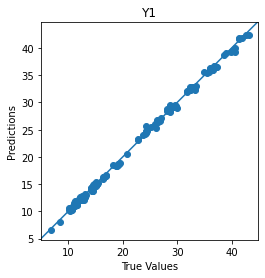

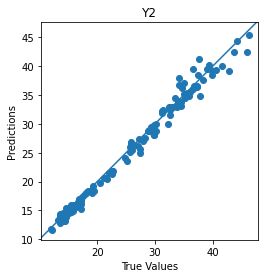

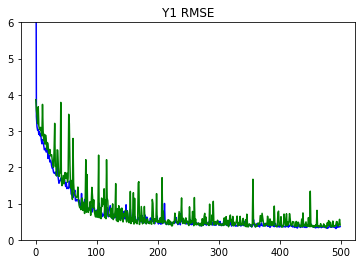

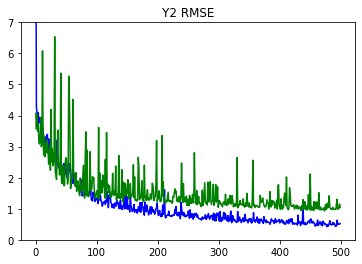

In [16]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)